# 📂 Notebook 02 – Outils et Visualisations DR5

Ce notebook regroupe des outils pratiques pour analyser, visualiser et affiner les spectres téléchargés. Il permet d’explorer facilement tes données sans avoir à relancer le pipeline complet.

Utilise ces outils pour :
- Vérifier le contenu des fichiers FITS (headers, métadonnées, etc.).
- Affiner la détection des raies spectrales avant d’entraîner ton modèle.
- Débugger rapidement des spectres problématiques.

#

---

In [6]:
import pandas as pd
import glob
import os
import sys

# Ajout du dossier 'src' pour accéder à tes outils personnalisés
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Dossier 'src' ajouté au sys.path : {module_path}")

# Configuration des chemins de données
RAW_DATA_DIR = "../data/raw/"
CATALOG_DIR = "../data/catalog/"
REPORT_DIR = "../reports/headers/"

# Recherche le dernier fichier de features généré dans data/processed
feature_files = sorted(glob.glob('../data/processed/features_*.csv'))
if feature_files:
    latest_feature_file = feature_files[-1]
    print(f"Chargement du dataset de features : {latest_feature_file}")
    features_df = pd.read_csv(latest_feature_file)
    print(f"Dataset chargé avec succès : {features_df.shape[0]} spectres.")
else:
    print("Aucun fichier de features trouvé dans ../data/processed/. Exécute d'abord le notebook 00_master_pipeline.ipynb.")

Chargement du dataset de features : ../data/processed\features_20250709T003637Z.csv
Dataset chargé avec succès : 3410 spectres.


##  Analyse du Header d’un Fichier FITS 

Cette cellule permet d’ouvrir un fichier FITS compressé ``.fits.gz`` et d’afficher son en-tête sous forme organisée et lisible, directement dans le notebook.

Elle t’aidera à :

- Vérifier rapidement la qualité des métadonnées (date, télescope, type d’objet, magnitudes, etc.).
- Identifier les informations clés (coordonnées, type de cible, plan d’observation, etc.).
- Détecter des incohérences ou des valeurs suspectes avant de lancer des traitements de masse.

**✨ Fonctionnalités principales**

Le script lit le header complet et le divise en sections thématiques :
- Informations générales : format, dimensions, etc.
- Métadonnées du fichier : date, auteur, origine.
- Paramètres du télescope : site, caméra, focus.
- Paramètres d’observation : dates, plan, identifiants.
- Position de l’objet : coordonnées célestes.
- Désignation et type de l’objet : ID, type, source.
- Magnitudes : valeurs mesurées sur plusieurs filtres.
- Type d’observation : cible, système de coordonnées.
- Expositions : temps d’expo, nombre d’expos, etc.

Chaque section affiche ses paramètres de façon lisible et alignée pour un débogage efficace.

Utilise le module ``astropy.io.fits`` pour une compatibilité parfaite avec les standards FITS.

In [2]:
import gzip
from astropy.io import fits
import os
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown

# --- Vérification et Configuration ---
# S'assurer que les variables nécessaires existent
if 'features_df' not in locals() or features_df.empty:
    print("ERREUR : Le DataFrame 'features_df' n'est pas défini ou est vide.")
    print("Veuillez d'abord exécuter la cellule de traitement des features.")
else:
    # Configuration du répertoire des données brutes
    RAW_DATA_DIR = "../data/raw/"

    # --- Création des Widgets ---
    
    # 1. Le Dropdown pour la sélection
    dropdown = widgets.Dropdown(
        options=features_df['file_path'].tolist(),
        description="Spectre :",
        layout=widgets.Layout(width='80%'),
        style={'description_width': 'initial'}
    )

    # 2. Un conteneur de sortie pour le header
    # C'est la clé : on effacera et réécrira uniquement dans ce conteneur.
    output_container = widgets.Output()

    # --- Fonctions de Callback ---

    def display_header(fits_path):
        """Affiche de manière organisée les informations de l'en-tête."""
        try:
            with gzip.open(fits_path, 'rb') as f_gz:
                with fits.open(f_gz, memmap=False) as hdul:
                    header = hdul[0].header
        except Exception as e:
            print(f"Erreur lors de l'ouverture de {fits_path} : {e}")
            return
    
        # Helper function pour formater les lignes de manière robuste
        def format_line(label, key, unit=""):
            value = header.get(key, 'N/A')
            # Ajoute une espace si une unité est présente
            unit_str = f" {unit}" if unit else ""
            return f"- **{label} :** `{value}`{unit_str}\n"

        # Construction du texte en Markdown
        md_output = f"### En-tête du fichier : `{os.path.basename(fits_path)}`\n---\n"
        
        # Section 1 : Informations Générales
        md_output += "#### 1. Informations Générales\n"
        md_output += format_line("Format du fichier (SIMPLE)", "SIMPLE")
        md_output += format_line("Type de pixels (BITPIX)", "BITPIX")
        md_output += f"- **Dimensions (NAXIS1 x NAXIS2) :** `{header.get('NAXIS1', 'N/A')} x {header.get('NAXIS2', 'N/A')}`\n"
        
        # Section 2 : Métadonnées du Fichier
        md_output += "\n#### 2. Métadonnées du Fichier\n"
        md_output += format_line("Nom du fichier original", "FILENAME")
        md_output += format_line("Identifiant d'observation", "OBSID")
        md_output += format_line("Auteur", "AUTHOR")
        md_output += format_line("Version des données", "DATA_V")
        md_output += format_line("Date de création", "DATE")
        
        # Section 3 : Paramètres du Télescope
        md_output += "\n#### 3. Paramètres du Télescope\n"
        md_output += format_line("Télescope", "TELESCOP")
        md_output += format_line("Longitude du site", "LONGITUD", "degrés")
        md_output += format_line("Latitude du site", "LATITUDE", "degrés")
        
        # Section 4 : Paramètres d'Observation
        md_output += "\n#### 4. Paramètres d'Observation\n"
        md_output += format_line("Date d'observation (UTC)", "DATE-OBS")
        md_output += format_line("Plan ID", "PLANID")
        md_output += format_line("Jour julien modifié (MJD)", "MJD")
        
        # Section 5 : Position et Désignation de l'Objet
        md_output += "\n#### 5. Position et Désignation\n"
        md_output += format_line("Désignation", "DESIG")
        md_output += format_line("Ascension droite (RA)", "RA", "degrés")
        md_output += format_line("Déclinaison (DEC)", "DEC", "degrés")
        
        # Section 6 : Informations sur la Fibre
        md_output += "\n#### 6. Informations sur la Fibre\n"
        md_output += format_line("ID de la fibre", "FIBERID")
        md_output += format_line("Type de fibre", "FIBERTYP")
        md_output += format_line("Nom de l'objet", "OBJNAME")
        md_output += format_line("Type d'objet (catalogue)", "OBJTYPE")
        
        # Section 7 : Magnitudes
        md_output += "\n#### 7. Magnitudes\n"
        md_output += format_line("Type de magnitude", "MAGTYPE")
        md_output += f"- **Magnitudes (u, g, r, i, z) :** `{header.get('MAG1', 'N/A')}`, `{header.get('MAG2', 'N/A')}`, `{header.get('MAG3', 'N/A')}`, `{header.get('MAG4', 'N/A')}`, `{header.get('MAG5', 'N/A')}`\n"

        # Section 8 : Paramètres de Réduction de Données
        md_output += "\n#### 8. Paramètres de Réduction\n"
        md_output += format_line("Correction héliocentrique", "HELIO")
        md_output += format_line("Vitesse radiale (correction)", "HELIO_RV", "km/s")
        md_output += format_line("Seeing", "SEEING", "arcsec")
        
        # Section 9 : Résultats de l'Analyse Pipeline
        md_output += "\n#### 9. Résultats de l'Analyse Pipeline\n"
        md_output += format_line("Classe", "CLASS")
        md_output += format_line("Sous-classe", "SUBCLASS")
        md_output += format_line("Redshift (z)", "Z")
        md_output += format_line("Erreur sur z", "Z_ERR")
        md_output += f"- **Rapport Signal/Bruit (SNR) :**\n"
        md_output += f"  - u-band: `{header.get('SNRU', 'N/A')}`\n"
        md_output += f"  - g-band: `{header.get('SNRG', 'N/A')}`\n"
        md_output += f"  - r-band: `{header.get('SNRR', 'N/A')}`\n"
        md_output += f"  - i-band: `{header.get('SNRI', 'N/A')}`\n"
        md_output += f"  - z-band: `{header.get('SNRZ', 'N/A')}`\n"

        # Affichage final dans le notebook
        display(Markdown(md_output))
        
    def on_dropdown_change(change):
        """Callback qui se déclenche lors du changement de sélection."""
        if change['type'] == 'change' and change['name'] == 'value':
            # On efface seulement le contenu du conteneur de sortie
            with output_container:
                clear_output(wait=True)
                
                # On reconstruit le chemin complet et on affiche le nouveau header
                full_path = os.path.join(RAW_DATA_DIR, change['new'])
                display_header(full_path)
    
    # --- Lancement de l'interface ---

    # Lier la fonction au dropdown
    dropdown.observe(on_dropdown_change, names='value')

    # Afficher les widgets
    # Le dropdown s'affiche une fois.
    # Le conteneur de sortie s'affiche en dessous et sera mis à jour dynamiquement.
    display(dropdown, output_container)

    # Afficher le header du premier élément par défaut
    with output_container:
        initial_path = os.path.join(RAW_DATA_DIR, dropdown.value)
        display_header(initial_path)

Dropdown(description='Spectre :', layout=Layout(width='80%'), options=('GAC_105N29_B1/spec-55863-GAC_105N29_B1…

Output()

#

## 📈 Affiner la Détection de Raies (Visualisation)
Une fois le pipeline exécuté, tu peux ajuster finement les paramètres de détection de raies (comme la prominence ou la fenêtre) sur un spectre choisi via un menu déroulant interactif. Cet outil te permet :
- De mieux calibrer la détection automatique des raies spectrales.
- De vérifier la cohérence des pics détectés avec les raies attendues.
- D’ajuster les paramètres avant de relancer le traitement en masse, pour éviter des datasets remplis de zéros.

Fonctionnement :
- Recharge le spectre choisi parmi ceux déjà traités (menu déroulant interactif).
- Normalise le flux et détecte les pics.
- Affiche le spectre avec les pics détectés et les raies cibles attendues.

Sauvegarde automatiquement la figure analysée dans le dossier ``images/spectre_visualisation/``, **créé s’il n’existe pas**.

Le fichier porte le nom du spectre, par exemple :
- ``images/spectre_visualisation/analysis_spec-XXXXX.png``


Affiche le spectre normalisé avec les pics détectés et les raies cibles.

🔧 Astuce : Une fois satisfait des paramètres, mets-les à jour dans ``processing.py`` pour les utiliser lors de la génération des features.

Dropdown(description='Spectre :', layout=Layout(width='70%'), options=('GAC_105N29_B1/spec-55863-GAC_105N29_B1…

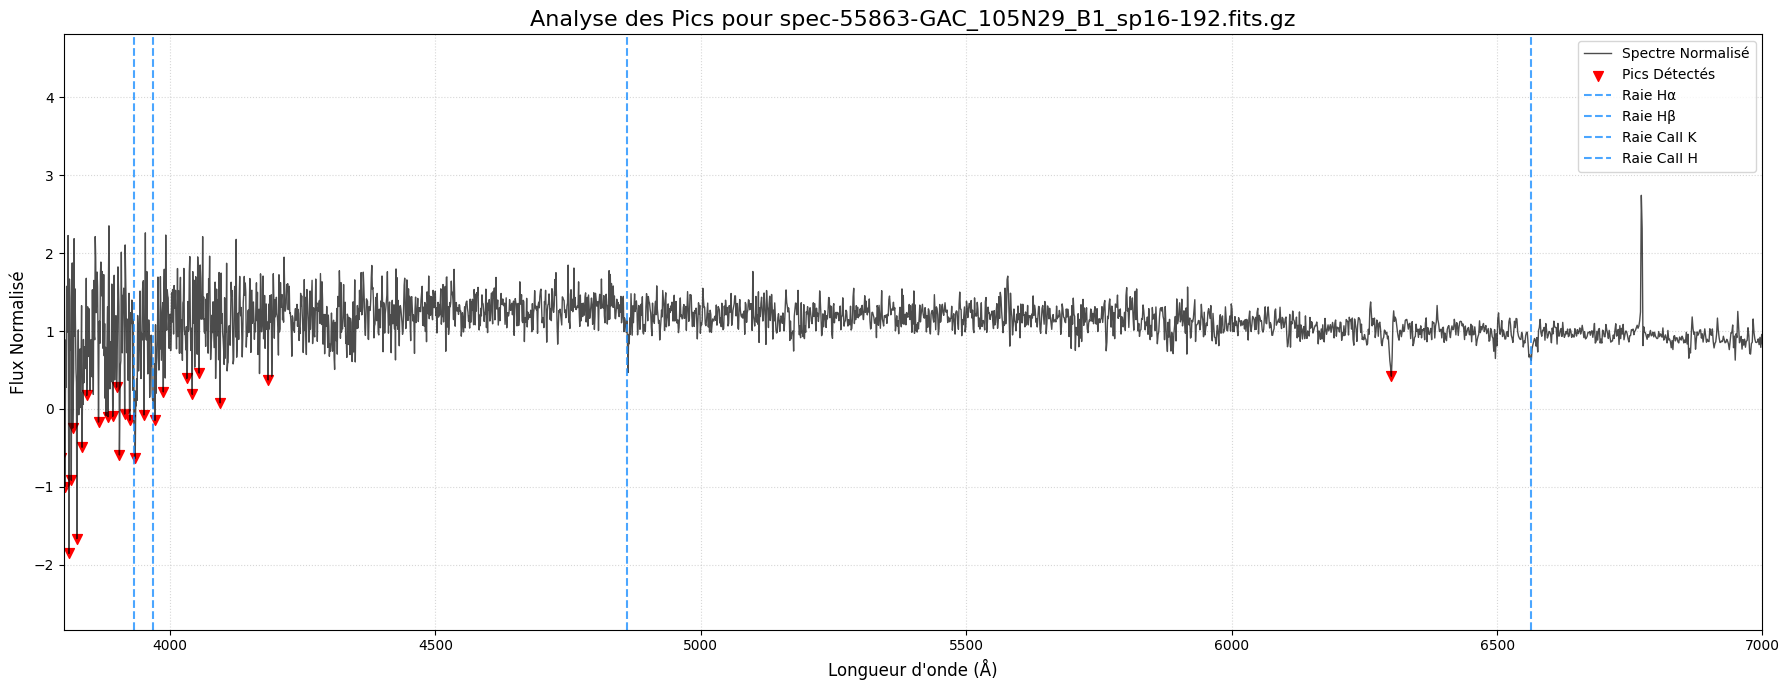

In [3]:
import matplotlib.pyplot as plt
import gzip
from astropy.io import fits
import ipywidgets as widgets
from IPython.display import display

# On importe les classes depuis les modules que l'on a ajoutés au path
from pipeline.preprocessor import SpectraPreprocessor
from pipeline.peak_detector import PeakDetector

# Vérifie que features_df existe et n'est pas vide
if 'features_df' in locals() and not features_df.empty:
    # Crée un dropdown pour choisir le spectre à visualiser
    dropdown = widgets.Dropdown(
        options=features_df['file_path'].tolist(),
        description='Spectre :',
        layout=widgets.Layout(width='70%')
    )
    display(dropdown)

    def on_select_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            sample_path = change['new']
            full_sample_path = os.path.join(RAW_DATA_DIR, sample_path)
            print(f"\n--- Visualisation du spectre sélectionné : {sample_path} ---")

            # Re-traitement du spectre sélectionné
            preprocessor = SpectraPreprocessor()
            peak_detector = PeakDetector(prominence=1.4, window=30)  # Ajuste tes paramètres ici

            try:
                # Étape A : Charger le spectre
                with gzip.open(full_sample_path, 'rb') as f_gz:
                    with fits.open(f_gz, memmap=False) as hdul:
                        wavelength, flux = preprocessor.load_spectrum(hdul)

                # Étape B : Normaliser le flux
                flux_norm = preprocessor.normalize_spectrum(flux)

                # Étape C : Détecter les pics
                peak_indices, _ = peak_detector.detect_peaks(wavelength, flux_norm)
                peak_wavelengths = wavelength[peak_indices]

                # --- Affichage graphique ---
                plt.figure(figsize=(18, 7))
                plt.plot(wavelength, flux_norm, label="Spectre Normalisé", color='black', alpha=0.7, linewidth=1)

                if len(peak_indices) > 0:
                    plt.scatter(peak_wavelengths, flux_norm[peak_indices], color='red', marker='v', s=50, label='Pics Détectés')

                for name, wl in peak_detector.target_lines.items():
                    plt.axvline(x=wl, color='dodgerblue', linestyle='--', alpha=0.8, label=f'Raie {name}')

                plt.title(f"Analyse des Pics pour {os.path.basename(sample_path)}", fontsize=16)
                plt.xlabel("Longueur d'onde (Å)", fontsize=12)
                plt.ylabel("Flux Normalisé", fontsize=12)
                plt.xlim(3800, 7000)
                plt.grid(True, linestyle=':', alpha=0.5)

                handles, labels = plt.gca().get_legend_handles_labels()
                by_label = dict(zip(labels, handles))
                plt.legend(by_label.values(), by_label.keys())

                plt.tight_layout()
                
                # Crée le dossier images/spectre_visualisation s'il n'existe pas
                output_dir = os.path.abspath(os.path.join('..', 'images', 'spectre_visualisation'))
                os.makedirs(output_dir, exist_ok=True)

                # Génère le chemin complet du fichier
                output_file = os.path.join(
                    output_dir,
                    f"analysis_{os.path.basename(sample_path).replace('.fits.gz','')}.png"
                )

                plt.savefig(output_file, dpi=150)
                plt.show()

                print(f"Analyse sauvegardée dans : analysis_{os.path.basename(sample_path).replace('.fits.gz','')}.png")

            except Exception as e:
                print(f"Erreur lors du traitement de ce spectre pour la visualisation : {e}")

    dropdown.observe(on_select_change, names='value')

else:
    print("Le DataFrame 'features_df' est vide. Veuillez d'abord exécuter le pipeline de traitement.\n")
    print(
        "Que faire ?\n"
        "• Lance le notebook 00_master_pipeline.ipynb pour traiter tes spectres bruts et générer le fichier features_*.csv.\n"
        "• Assure-toi d’avoir téléchargé au moins un lot de spectres via 01_download_spectra.ipynb.\n"
        "• Vérifie que le dossier 'data/raw/' contient bien des fichiers .fits.gz à traiter.\n"
        "\n"
        "Une fois le pipeline exécuté avec succès, reviens ici : le DataFrame sera chargé automatiquement et tu pourras visualiser tes spectres."
    )


### Tuning interactif

In [4]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import gzip
from astropy.io import fits
import sys
import os

# Chemin du dossier src/ relatif au répertoire de travail actuel
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)  # Ajoute src/ en priorité
    print(f"Dossier 'src' ajouté au sys.path : {module_path}")
else:
    print(f"Dossier 'src' déjà présent dans sys.path : {module_path}")

from pipeline.preprocessor import SpectraPreprocessor
from pipeline.peak_detector import PeakDetector

# -- Initialisation --
preprocessor = SpectraPreprocessor()

# Widgets : sliders pour hyperparamètres
slider_prominence = widgets.FloatSlider(
    value=0.4, min=0.05, max=2.0, step=0.05,
    description="Prominence:", continuous_update=False
)
slider_window = widgets.IntSlider(
    value=15, min=1, max=50, step=1,
    description="Window:", continuous_update=False
)

# Conteneur de sortie
output_plot = widgets.Output()

def update_plot(*args):
    with output_plot:
        clear_output(wait=True)
        
        # Charger le spectre sélectionné
        selected_file = dropdown.value
        fits_path = os.path.join(RAW_DATA_DIR, selected_file)
        
        try:
            with gzip.open(fits_path, 'rb') as f_gz:
                with fits.open(f_gz, memmap=False) as hdul:
                    wavelength, flux = preprocessor.load_spectrum(hdul)
            flux_norm = preprocessor.normalize_spectrum(flux)
            
            # PeakDetector avec hyperparamètres dynamiques
            detector = PeakDetector(prominence=slider_prominence.value, window=slider_window.value)
            matched_lines = detector.analyze_spectrum(wavelength, flux_norm)
            
            # Affichage
            fig, ax = plt.subplots(figsize=(12, 4))
            ax.plot(wavelength, flux_norm, label="Spectre Normalisé", lw=0.5)
            peaks_idx, _ = detector.detect_peaks(wavelength, flux_norm)
            ax.plot(wavelength[peaks_idx], flux_norm[peaks_idx], "rv", label="Pics Détectés")
            # Raies connues
            for line_name, target_wl in detector.target_lines.items():
                ax.axvline(target_wl, ls="--", color="blue", label=f"Raie {line_name}")
            ax.set_title(f"Analyse des Pics pour {os.path.basename(fits_path)}")
            ax.set_xlabel("Longueur d'onde [Å]")
            ax.set_ylabel("Flux Normalisé")
            ax.legend(loc="upper right")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Erreur lors de l'analyse du spectre : {e}")

# Observer sliders + dropdown
slider_prominence.observe(update_plot, names="value")
slider_window.observe(update_plot, names="value")
dropdown.observe(update_plot, names="value")

# Affichage
display(widgets.HBox([slider_prominence, slider_window]))
display(output_plot)

# Première mise à jour
update_plot()


Dossier 'src' déjà présent dans sys.path : c:\Users\alexb\Documents\Google_Cloud\alex_labs_google_sprint\astro_spectro_git\src


Output()

#

## 🔍 Analyse des valeurs nulles dans les features


CSV chargé avec 3410 lignes et 7 colonnes.
4 colonnes de features détectées.


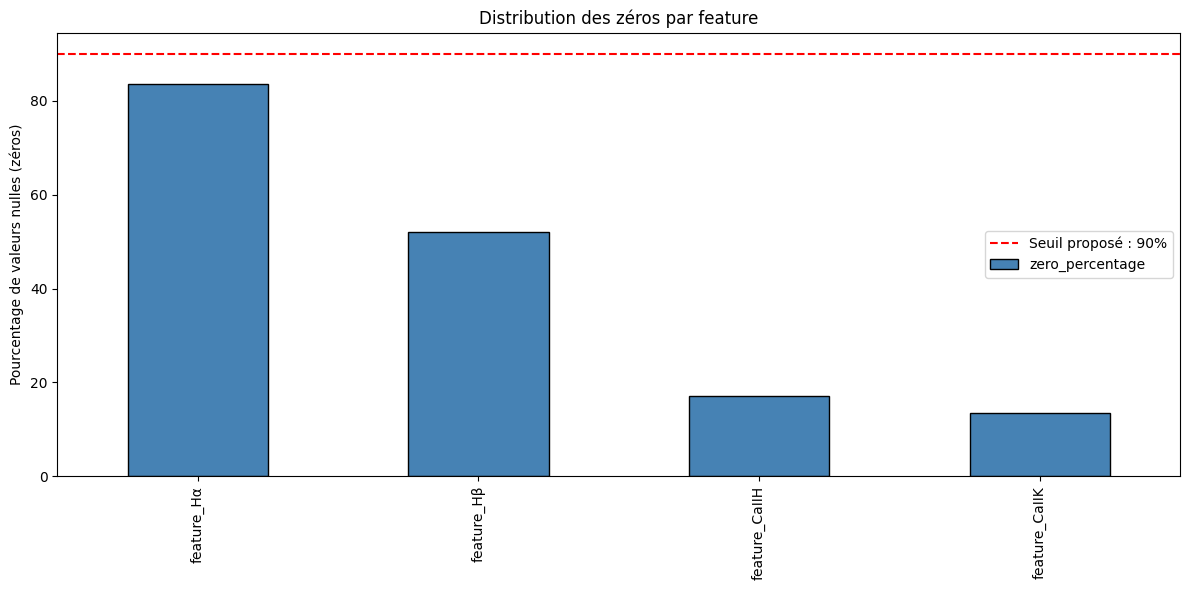


Features à retirer (>= 90% de zéros) :


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Charger le CSV de features (remplace le chemin par le tien)
csv_path = "../data/processed/features_20250709T003637Z.csv"  # <- adapte si besoin
df = pd.read_csv(csv_path)
print(f"CSV chargé avec {df.shape[0]} lignes et {df.shape[1]} colonnes.")

# 2) Identifier les colonnes de features (exclure label, file_path...)
feature_cols = [col for col in df.columns if col.startswith("feature_")]
print(f"{len(feature_cols)} colonnes de features détectées.")

# 3) Calculer pourcentage de zéros par colonne
zero_stats = {}
for col in feature_cols:
    zero_count = (df[col] == 0).sum()
    zero_pct = 100 * zero_count / len(df)
    zero_stats[col] = zero_pct

# Convertir en DataFrame trié pour analyse
zero_df = pd.DataFrame.from_dict(zero_stats, orient="index", columns=["zero_percentage"]).sort_values("zero_percentage", ascending=False)

# 4) Visualiser la distribution des pourcentages de zéros
plt.figure(figsize=(12, 6))
zero_df["zero_percentage"].plot(kind="bar", color="steelblue", edgecolor="black")
plt.axhline(90, color="red", linestyle="--", label="Seuil proposé : 90%")
plt.ylabel("Pourcentage de valeurs nulles (zéros)")
plt.title("Distribution des zéros par feature")
plt.legend()
plt.tight_layout()
plt.show()

# 5) Lister les features dépassant le seuil proposé (90%)
threshold = 90
to_remove = zero_df[zero_df["zero_percentage"] >= threshold].index.tolist()
print(f"\nFeatures à retirer (>= {threshold}% de zéros) :")
for f in to_remove:
    print(f"  - {f}")